## Deep Learning -Week 5: Generative Adversarial Networks (GAN) - Monet Images¶

In this project, we will use Generative Adversarial Networks to generate "Monet-like" images from exiting pictures as per the Kaggle competion.

This Kagge task consists in building a GAN that generates 7,000 to 10,000 Monet-style images.

The Kaggle page that contains the details of the compentions can be found inthis URL:

https://www.kaggle.com/competitions/gan-getting-started/overview

This notebook can be found in Github :

https://github.com/laguila11/GAN-Monet

## Step 1. Brief description of the problem and data

In this project, we will have access to a dataset of Monet portraits and diverse picture to train the GAN models.

The following data sets are provided in the Kaggle page to train and test the model:

Input Files: https://www.kaggle.com/competitions/gan-getting-started/data

monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format


Submission : The kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.


## Step 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In this section we will load the dataset of images, normalize the pictures data, and perform some basic analysis on their contents.

Also we will visualize the different properties to get a first intuition of the contents of the data and some basic statistics.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
import numpy as np
from glob import glob
import os
from PIL import Image
import time
import matplotlib.pyplot as plt

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32  
BUFFER_SIZE = 1000

Number of Monet images: 300
Number of Photo images: 7038


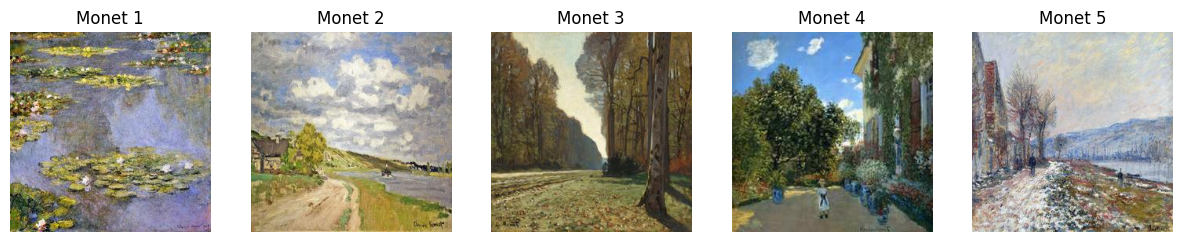

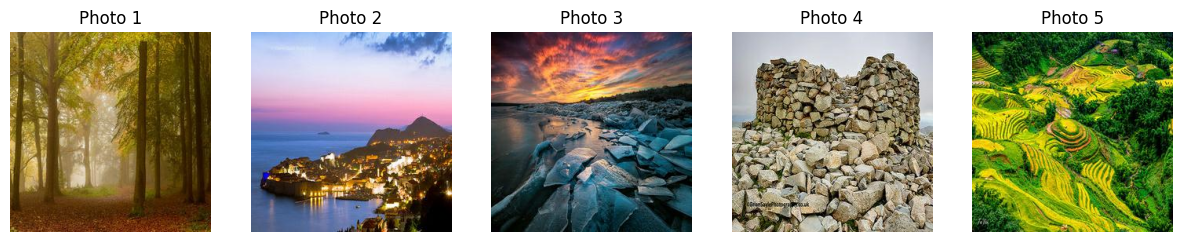

Unique image shapes in Monet dataset: {(256, 256)}
Unique image shapes in Photo dataset: {(256, 256)}


In [2]:
# Load Monet and Photo datasets
monet_jpg_paths = glob('/kaggle/input/gan-getting-started/monet_jpg/*.jpg')
photo_jpg_paths = glob('/kaggle/input/gan-getting-started/photo_jpg/*.jpg')

# Function to load and decode images
def decode_pic(image_path):
    image = Image.open(image_path)
    image = image.resize((IMG_HEIGHT, IMG_WIDTH))
    return np.array(image)

# Function to display images
def display_pics(image_list, titles=None, cols=5):
    rows = len(image_list) // cols + 1
    plt.figure(figsize=(15, 5 * rows))
    for i, img in enumerate(image_list):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# 1. Basic Summary of the Dataset
def dataset_summary():
    print(f"Number of Monet images: {len(monet_jpg_paths)}")
    print(f"Number of Photo images: {len(photo_jpg_paths)}")

# 2. Display Sample Images
def display_sample_images(num_samples=5):
    monet_samples = [decode_pic(path) for path in monet_jpg_paths[:num_samples]]
    photo_samples = [decode_pic(path) for path in photo_jpg_paths[:num_samples]]
    
    display_pics(monet_samples, titles=[f"Monet {i+1}" for i in range(num_samples)])
    display_pics(photo_samples, titles=[f"Photo {i+1}" for i in range(num_samples)])

# 3. Image Shape and Size Analysis
def analyze_image_shapes():
    monet_shapes = [Image.open(path).size for path in monet_jpg_paths]
    photo_shapes = [Image.open(path).size for path in photo_jpg_paths]
    
    unique_monet_shapes = set(monet_shapes)
    unique_photo_shapes = set(photo_shapes)
    
    print(f"Unique image shapes in Monet dataset: {unique_monet_shapes}")
    print(f"Unique image shapes in Photo dataset: {unique_photo_shapes}")


# EDA functions
if __name__ == "__main__":
    # 1. Basic Summary of the Dataset
    dataset_summary()

    # 2. Display Sample Images
    display_sample_images(num_samples=5)

    # 3. Analyze Image Shapes
    analyze_image_shapes()



### Observations

We have 300 Monet images and 7000 photos real world photos.

There is no need to clean the data. Both the Monet and photo images have the required size. 

We will now proceed to load and process the images converting them ready to train the models

In [3]:
# Load and process images

#  TFRecord paths
monet_tfrec_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_tfrec_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_tfrecord(filenames, labeled=False):
    raw_image_dataset = tf.data.TFRecordDataset(filenames)
    
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    
    def _parse_image_function(example_proto):
        content = tf.io.parse_single_example(example_proto, image_feature_description)
        image = decode_image(content['image'])
        return image
    
    return raw_image_dataset.map(_parse_image_function)

# Load datasets
monet_dataset = load_tfrecord(monet_tfrec_files)
photo_dataset = load_tfrecord(photo_tfrec_files)

In [4]:
# Pre-processing of the images

# Normalize images from [-1, 1].

# Preprocessing functinon
def preprocess_image(image):
    # Normalizar las imágenes entre [-1, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image - 0.5) * 2
    return image

def preprocess_dataset(dataset):
    dataset = dataset.map(lambda x: preprocess_image(x))
    dataset = dataset.shuffle(buffer_size=1000).batch(1)  
    return dataset

# Aplies preprocessing to the Monet and photos datasets 
monet_dataset = preprocess_dataset(monet_dataset)
photo_dataset = preprocess_dataset(photo_dataset)

## Step 3.  Model Architecture

Here we will describe the architecture used to build the generator and discriminator models.

We will show some of the iterations perform to optimize the model based on the kaggle score. There are many iterations and tuning that have been done outside of this notebook. Here, we are including the most significant changes in the performance of the models. 

At the end of the section, we will compare the different architectures and prepare for the results and conclusions.

### Model 1

1. Discriminator Model Architecture:

Uses a series of convolutional layers (Conv2D) with 64 and 128 filters, kernel size 4, and stride 2. 
LeakyReLU activations are used after each convolutional layer, which helps mitigate the dying ReLU problem and allows a small, non-zero gradient when the unit is not active.
The output is a single-channel convolutional layer (Conv2D with 1 filter)

2. Generator Model Architecture:

The Downsampling part uses two Conv2D layers to reduce the spatial resolution. It starts with 32 filters, then increases to 64, with kernel size 4 and stride 2. ReLU activations are used to introduce non-linearity.
The Upsampling part uses two Conv2DTranspose layers to restore the image's spatial dimensions (opposite of downsampling). It starts with 64 filters and then decreases to 32. The final Conv2DTranspose layer has 3 filters (to output an RGB image).

The final output uses a tanh activation function, which is common in GANs as it produces values between -1 and 1, matching the normalized range of images used in these models.

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
import numpy as np
from glob import glob
import os
from PIL import Image
import time
import matplotlib.pyplot as plt


# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32  
BUFFER_SIZE = 1000

# Build the Discriminator (simplified)
def build_discriminator():
    input_img = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(input_img)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return Model(inputs=input_img, outputs=x)

def build_generator():
    input_img = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    # Downsample
    x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)  # Reduce filters
    x = ReLU()(x)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)
    
    # Upsample
    x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)
    
    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')(x)
    
    x = tf.keras.layers.Activation('tanh')(x)
    
    return Model(inputs=input_img, outputs=x)

# Define loss functions
def generator_loss_fn(disc_generated_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)

def discriminator_loss_fn(real_output, generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_output), generated_output)
    return (real_loss + generated_loss) * 0.5

# Train CycleGAN
class SimpleCycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(SimpleCycleGAN, self).__init__()
        self.generator_g = generator_g  # Photo to Monet
        self.generator_f = generator_f  # Monet to Photo
        self.discriminator_x = discriminator_x  # Monet Discriminator
        self.discriminator_y = discriminator_y  # Photo Discriminator

    def compile(self, gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt):
        super(SimpleCycleGAN, self).compile()
        self.gen_g_opt = gen_g_opt
        self.gen_f_opt = gen_f_opt
        self.disc_x_opt = disc_x_opt
        self.disc_y_opt = disc_y_opt
    @tf.function  # Accelerates the train_step function by compiling it to a static graph
    def train_step(self, batch_data):
        real_x, real_y = batch_data

        # Photo -> Monet
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)

            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)

            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # Calculate losses
            gen_g_loss = generator_loss_fn(disc_fake_y)
            gen_f_loss = generator_loss_fn(disc_fake_x)

            disc_x_loss = discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_y_loss = discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Calculate gradients
        generator_g_gradients = tape.gradient(gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        # Apply gradients
        self.gen_g_opt.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.gen_f_opt.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.disc_x_opt.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.disc_y_opt.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": gen_g_loss,
            "gen_f_loss": gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }

# Build and compile the model
generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo
discriminator_x = build_discriminator()  # Discriminator for Monet
discriminator_y = build_discriminator()  # Discriminator for Photo

# Optimizers
gen_g_opt = Adam(2e-4, beta_1=0.5)
gen_f_opt = Adam(2e-4, beta_1=0.5)
disc_x_opt = Adam(2e-4, beta_1=0.5)
disc_y_opt = Adam(2e-4, beta_1=0.5)

# Initialize the model
simple_cyclegan = SimpleCycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
simple_cyclegan.compile(gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt)

In [6]:
EPOCHS = 150
# Training loop with progress bar
train_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Initialize the progress bar for each epoch
    steps_per_epoch = len(list(train_dataset))
    progbar = Progbar(steps_per_epoch)
    
    for step, batch in enumerate(train_dataset):
        simple_cyclegan.train_step(batch)
        
        # Update the progress bar at each step
        progbar.update(step + 1)

Epoch 1/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step
Epoch 2/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 3/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 4/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 5/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 6/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 7/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 8/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 9/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 10/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 11/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 12/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 13/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 14/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 15/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 16/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 17/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 18/150
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 19/150
300/3

### Kaggle Score 

Epochs  50 - Score: 178.10415

Epochs 100 - Score: 171.22246

Epochs 150 - Score: 164.29687

Epochs 200 - Score: 188.73315


### Submission and visualizations

This section generates the images to submission for Kaggle and displays some of the resulting images against the originals

In [7]:
def generate_and_save_images(generator, test_input, save_dir, num_images=None):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # If num_images is None, process the entire dataset
    if num_images is None:
        num_images = len(list(test_input))  # Use the entire dataset
    
    for i, img in enumerate(test_input.take(num_images)):
        #generated_img = generator(img, training=False)[0].numpy().squeeze() * 255.astype(np.uint8)
        generated_img = (generator_g(img, training=False)[0].numpy().squeeze() * 255).astype(np.uint8)
        #generated_img = (generated_img * 127.5 + 127.5).numpy().astype(np.uint8)  # Rescale to [0, 255]
        
        img = Image.fromarray(generated_img)
        img.save(os.path.join(save_dir, f"img_{i+1}.jpg"))

# Generate Monet-style images from the full photo dataset and save them
generate_and_save_images(generator_g, photo_dataset, save_dir="imgs")

In [8]:
import zipfile


def create_zip_from_directory(directory_path, output_zipfile):
    try:
        # Ensure the parent directory of the output zip file exists
        output_dir = os.path.dirname(output_zipfile)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)  # Create directory if it doesn't exist

        # Create the zip file in write mode, with allowZip64 enabled for large files
        with zipfile.ZipFile(output_zipfile, 'w', allowZip64=True) as zipf:
            # Walk through the directory
            for foldername, subfolders, filenames in os.walk(directory_path):
                for filename in filenames:
                    # Create the full file path
                    file_path = os.path.join(foldername, filename)
                    # Add file to the zip, preserving the directory structure
                    zipf.write(file_path, os.path.relpath(file_path, directory_path))

        print(f"Zip file created at: {output_zipfile}")

    except Exception as e:
        print(f"Error occurred: {e}")

# Example usage
directory_to_zip = './imgs/'  # Replace with your directory
output_zip = './images.zip'  # Ensure this path exists

create_zip_from_directory(directory_to_zip, output_zip)

Zip file created at: ./images.zip


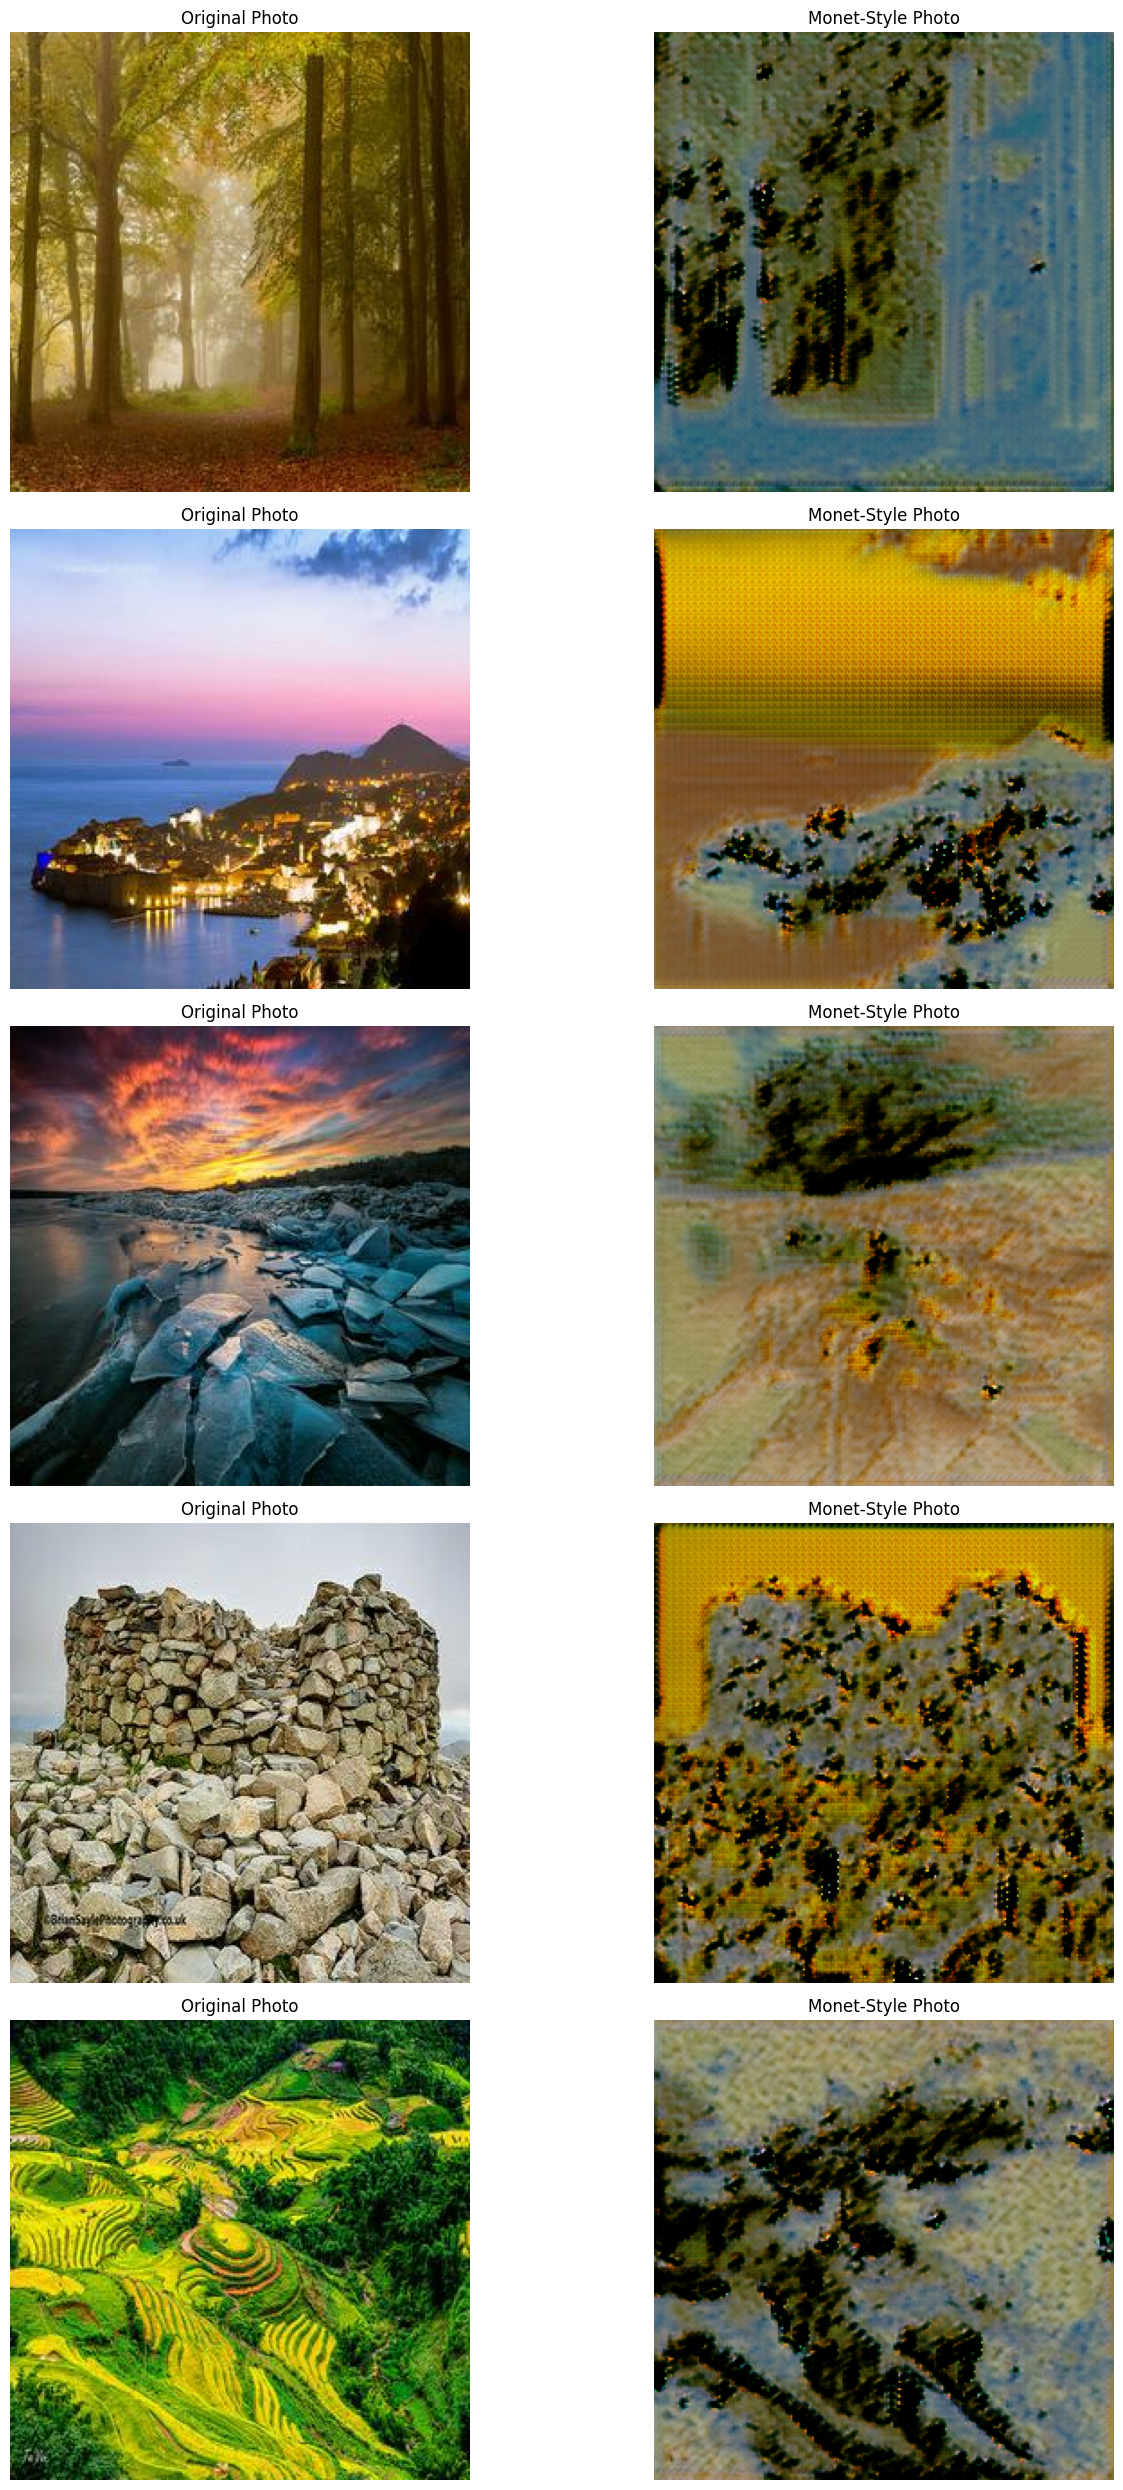

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])  # Resize image
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Function to display original and transformed images side by side
def display_original_vs_transformed(generator, image_paths, num_images=5):
    plt.figure(figsize=(15, num_images * 5))
    
    for i, image_path in enumerate(image_paths[:num_images]):
        original_image = load_and_preprocess_image(image_path)
        original_image = tf.expand_dims(original_image, axis=0)  # Add batch dimension

        # Generate the transformed image
        transformed_image = generator(original_image, training=False)
        
        # Remove batch dimension and rescale images to [0, 1] for display
        original_image = (original_image[0] * 0.5) + 0.5  # From [-1, 1] to [0, 1]
        transformed_image = (transformed_image[0] * 0.5) + 0.5  # From [-1, 1] to [0, 1]

        # Plot original and transformed images
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(original_image)
        plt.title('Original Photo')
        plt.axis('off')

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(transformed_image)
        plt.title('Monet-Style Photo')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



# Select sample images
sample_image_paths = photo_jpg_paths[:5]  

# Display the images
display_original_vs_transformed(generator_g, sample_image_paths, num_images=5)


###  Model 2 

Discriminator:

Added four convolutional blocks with increasing filters (64 → 128 → 256 → 512) to capture finer details.
Added Batch Normalization after each convolution layer for better stability.
Each convolution layer is followed by LeakyReLU for non-linearity.

Generator:

Incorporated residual blocks to introduce skip connections. This helps with gradient flow, especially in deeper networks, and helps in better training.
Added Batch Normalizaion to all convolution layers for better model convergence and training stability.
Kept the overall structure with downsampling, residual blocks, and upsampling similar to CycleGAN’s original architecture.


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, ReLU, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Build a more complex Discriminator
def build_discriminator():
    input_img = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Block 1
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(input_img)
    x = LeakyReLU()(x)

    # Block 2
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Block 3
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Block 4
    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Output
    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=input_img, outputs=x)

# Residual block for the Generator
def residual_block(x, filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    skip = x

    # First conv block
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv block
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)

    # Skip connection
    return Add()([x, skip])

# Build a more complex Generator
def build_generator():
    input_img = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Downsample
    x = Conv2D(64, kernel_size=7, strides=1, padding='same')(input_img)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    for _ in range(9):  # 9 residual blocks
        x = residual_block(x, 256)

    # Upsample
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final output layer
    x = Conv2D(3, kernel_size=7, strides=1, padding='same')(x)
    x = tf.keras.layers.Activation('tanh')(x)

    return tf.keras.Model(inputs=input_img, outputs=x)

# Define loss functions
def generator_loss_fn(disc_generated_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)

def discriminator_loss_fn(real_output, generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_output), generated_output)
    return (real_loss + generated_loss) * 0.5

# Train CycleGAN
class SimpleCycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(SimpleCycleGAN, self).__init__()
        self.generator_g = generator_g  # Photo to Monet
        self.generator_f = generator_f  # Monet to Photo
        self.discriminator_x = discriminator_x  # Monet Discriminator
        self.discriminator_y = discriminator_y  # Photo Discriminator

    def compile(self, gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt):
        super(SimpleCycleGAN, self).compile()
        self.gen_g_opt = gen_g_opt
        self.gen_f_opt = gen_f_opt
        self.disc_x_opt = disc_x_opt
        self.disc_y_opt = disc_y_opt

    @tf.function
    def train_step(self, batch_data):
        real_x, real_y = batch_data

        # Photo -> Monet
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)

            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)

            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # Calculate losses
            gen_g_loss = generator_loss_fn(disc_fake_y)
            gen_f_loss = generator_loss_fn(disc_fake_x)

            disc_x_loss = discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_y_loss = discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Calculate gradients
        generator_g_gradients = tape.gradient(gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        # Apply gradients
        self.gen_g_opt.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.gen_f_opt.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.disc_x_opt.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.disc_y_opt.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": gen_g_loss,
            "gen_f_loss": gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }

# Build and compile the model
generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo
discriminator_x = build_discriminator()  # Discriminator for Monet
discriminator_y = build_discriminator()  # Discriminator for Photo

# Optimizers
gen_g_opt = Adam(2e-4, beta_1=0.5)
gen_f_opt = Adam(2e-4, beta_1=0.5)
disc_x_opt = Adam(2e-4, beta_1=0.5)
disc_y_opt = Adam(2e-4, beta_1=0.5)

# Initialize the model
cyclegan = SimpleCycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cyclegan.compile(gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt)


## Kaggle Score

We run this model for 100 epochs and generate the outputs

Score: 251.33876

### Model 3

Key Changes and Additions:

Simplified Architecture: A simple generator and discriminator model with a few layers.
Dropout for Regularization: Dropout is added to the generator to prevent overfitting and help improve generalization.

Cycle Consistency Loss: The model uses the cycle consistency loss to maintain image structure during transformations, which is crucial for the CycleGAN.
Tuned Learning Rate: A lower learning rate (1e-4) for better stability during GAN training.



In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, ReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Build a simplified Discriminator
def build_discriminator():
    input_img = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(input_img)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    
    return tf.keras.Model(inputs=input_img, outputs=x)

# Build a simplified Generator with Dropout for Regularization
def build_generator():
    input_img = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    # Downsample
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(input_img)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Dropout for Regularization
    x = Dropout(0.5)(x)
    
    # Upsample
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')(x)
    
    x = tf.keras.layers.Activation('tanh')(x)
    
    return tf.keras.Model(inputs=input_img, outputs=x)

# Define loss functions
def generator_loss_fn(disc_generated_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)

def discriminator_loss_fn(real_output, generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_output), generated_output)
    return (real_loss + generated_loss) * 0.5

# Cycle Consistency Loss
def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

# Train CycleGAN Model
class SimpleCycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(SimpleCycleGAN, self).__init__()
        self.generator_g = generator_g  # Photo to Monet
        self.generator_f = generator_f  # Monet to Photo
        self.discriminator_x = discriminator_x  # Monet Discriminator
        self.discriminator_y = discriminator_y  # Photo Discriminator

    def compile(self, gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt):
        super(SimpleCycleGAN, self).compile()
        self.gen_g_opt = gen_g_opt
        self.gen_f_opt = gen_f_opt
        self.disc_x_opt = disc_x_opt
        self.disc_y_opt = disc_y_opt

    @tf.function
    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Forward cycle (photo -> Monet -> photo)
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)

            # Backward cycle (Monet -> photo -> Monet)
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            # Discriminator outputs
            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # Calculate losses
            gen_g_loss = generator_loss_fn(disc_fake_y)
            gen_f_loss = generator_loss_fn(disc_fake_x)
            
            cycle_loss_x = cycle_consistency_loss(real_x, cycled_x)
            cycle_loss_y = cycle_consistency_loss(real_y, cycled_y)
            
            total_gen_g_loss = gen_g_loss + cycle_loss_y
            total_gen_f_loss = gen_f_loss + cycle_loss_x
            
            disc_x_loss = discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_y_loss = discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Calculate gradients
        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        # Apply gradients
        self.gen_g_opt.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.gen_f_opt.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.disc_x_opt.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.disc_y_opt.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }

# Build and compile the model
generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo
discriminator_x = build_discriminator()  # Discriminator for Monet
discriminator_y = build_discriminator()  # Discriminator for Photo

# Optimizers with adjusted learning rate
gen_g_opt = Adam(1e-4, beta_1=0.5)  # Lowered learning rate for more stable training
gen_f_opt = Adam(1e-4, beta_1=0.5)
disc_x_opt = Adam(1e-4, beta_1=0.5)
disc_y_opt = Adam(1e-4, beta_1=0.5)

# Initialize the model
cyclegan = SimpleCycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cyclegan.compile(gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt)


#### Kaggle Score

We run this model with 100 epochs and obtain this Kaggle Score

Score: 287.47590

## Step 4. Results and Analysis

### Models Comparison


**Summary table of the 6 combinations tried**

| Combination | Discriminator - Generator |  Epochs | Kaggle Score (lower = better)|
|----------|----------|----------|----------|
| 1.Model 1 | Simple | 50 | 178.10415 |
| 2.Model 1 | Simple | 100 | 171.22246 |
| 3.Model 1 | Simple | 150 | 164.29687 |
| 4.Model 1 | Simple | 200 | 188.73315 |
| 5.Model 2 | Very Complex with batch normalization| 100 | 251.33876 |
| 6.Model 3 | Complex with dropout for regularization| 100 |287.47590 |


### Results Analysis

**Best Model:** Model 1 with the Simple Discriminator and Simple Generator at 150 epochs performed the best with a Kaggle score of 164.29687. This suggests that the simpler model was able to generalize better and was optimal when trained for an appropriate number of epochs.

Overfitting in Simple Model: Model 1 at 200 epochs saw an increase in the Kaggle score (worse performance), likely due to overfitting. This shows that beyond 150 epochs, the model starts to memorize the data instead of generalizing well.

Too Much Complexity: The Very Complex Model (Model 2) and Model with Dropout (Model 3) performed significantly worse, suggesting that for this task, simpler architectures performed better. The additional layers, batch normalization, and dropout may have added too much complexity without yielding improved results, potentially due to issues with overfitting, underfitting, or convergence difficulties.

# Step 5. Conclusion

**Simplicity and Optimal Training Duration:**  A simpler model architecture (Model 1) combined with an optimal number of training epochs (150) worked best. This highlights the importance of finding the right balance between model complexity and training time to avoid both underfitting and overfitting.

**Complexity** Does Not Always Lead to Better Performance: Increasing model complexity through additional layers, batch normalization, and dropout (Model 2 and Model 3) did not improve performance. In fact, it led to worse results, suggesting that in this case, simpler architectures are more suitable for the task at hand.

**Regularization** Needs to Be Carefully Tuned: The use of dropout in Model 3 didn’t provide the expected regularization benefits and may have instead led to underfitting. This underscores the need for careful tuning when introducing regularization techniques.